In [ ]:
# this is if you want to run the notebook on google colab

# ! git  clone -b bear-face-automatic-annotation --single-branch  https://gitlab.com/fruitpunch/projects/ai-for-bears/face-detection-and-segmentation/albear.git
# ! git clone https://github.com/IDEA-Research/GroundingDINO.git

# # !nvcc --version
# # !which nvcc
# %env CUDA_HOME=/usr/local/cuda

# ! cd GroundingDINO && pip install -e .

# # you need to restart the runtime for the installation to be succesful

In [1]:
import glob
import sys
from tqdm import tqdm
from PIL import Image
from os import path
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import csv
import random
import pandas as pd
import math

from tqdm.notebook import tqdm

In [2]:
from multiprocessing import Process, Queue, cpu_count
print(f'{cpu_count()} cpus')
import groundingdino

sys.path.append('../../src/bearfacelabeling')
import predict

8 cpus


/home/chouffe/fruitpunch/challenges/bear/src/groundingdino/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [3]:
input_dir = '../../data/01_raw/Hack the Planet'
sub_dirs = [
    '../../data/01_raw/Hack the Planet/images/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/Season5 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/BearFeedingPoints - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Bison - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season1 -  bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season2 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season3 - bears only',
    '../../data/01_raw/Hack the Planet/images/frameOutput/data/Season5 - bears only'
]
output_dir = '../../data/07_model_output/bearfacelabeling/Hack the Planet'

In [4]:
image_extensions = [".jpg", ".PNG", ".JPG"]
image_paths = [ path for folder in sub_dirs for ext in image_extensions for path in glob.iglob('%s/**/*%s' % (folder, ext), recursive=True)]

# Path(output_dir).mkdir(parents=True, exist_ok=True)
# with open(path.join(output_dir, 'list_of_images.csv'), 'w') as f:
#     writer = csv.writer(f)
#     for p in image_paths:
#         rel_p = path.relpath(p, input_dir)
#         writer.writerow([rel_p])

#import pickle
# with open('list_of_images', 'wb') as fp:
#     pickle.dump(image_paths, fp)

# import pickle
# with open ('list_of_images', 'rb') as fp:
#     image_paths = pickle.load(fp)


print(len(image_paths))

13923


In [5]:
model_checkpoint_path = '/content/drive/MyDrive/FruitPunch AI/groundingdino_swint_ogc.pth'
model_checkpoint_path = '../../data/06_models/GroundingDINO/groundingdino_swint_ogc.pth'
device = "cpu"
model = predict.Model(model_checkpoint_path, device = device)

/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## Generate annotations

In [6]:
len(image_paths)

13923

In [17]:
subset = image_paths[:10]

#for image_path in tqdm_notebook(image_paths):
for image_path in tqdm(subset):
  image = Image.open(image_path)
  bbox = model.predict(image)

  relative_image_path = path.relpath(image_path, input_dir)
  relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
  ann_path = path.join(output_dir, relative_ann_path)
  Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)

  with open(ann_path, 'w') as f:
    writer = csv.writer(f)
    if bbox:
        #f.write_row([0] + bbox)
        f.write(str(bbox))

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
def bbox_to_string(bbox: list[float]) -> str:
    x, y, width, height = bbox
    return f"{x} {y} {width} {height}"


def parse_bbox(s: str) -> list[float]:
    x, y, width, height = [float(x) for x in s.split(" ")]
    return [x, y, width, height]

In [8]:
bbox_to_string([0.494128555059433, 0.45449402928352356, 0.1353732794523239, 0.15825387835502625])
parse_bbox(bbox_to_string([0.494128555059433, 0.45449402928352356, 0.1353732794523239, 0.15825387835502625]))

[0.494128555059433,
 0.45449402928352356,
 0.1353732794523239,
 0.15825387835502625]

In [11]:
subset = image_paths[:10]


In [ ]:
subset = image_paths[:10]

#for image_path in tqdm_notebook(image_paths):
for image_path in tqdm(subset):
  image = Image.open(image_path)
  bbox = model.predict(image)

  relative_image_path = path.relpath(image_path, input_dir)
  relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
  ann_path = path.join(output_dir, relative_ann_path)
  Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)

  with open(ann_path, 'w') as f:
    if bbox:
        x, y, width, height = bbox
        f.write(bbox_to_string(bbox))

## Generate annotations using multiprocessing to load images
(in google colab loading images is a bottleneck)

In [60]:
def worker(input, output):
    for path in iter(input.get, 'STOP'):
      image = Image.open(path)
      output.put((path, image))

task_queue = Queue()
image_queue = Queue(maxsize = 20)

number_of_processes = 6

for p in image_paths:
  task_queue.put(p)

for i in range(number_of_processes):
  task_queue.put('STOP')

for i in range(number_of_processes):
  Process(target=worker, args=(task_queue, image_queue)).start()

# i need to load three images in parallel

n_stops = 0

# todo: list the paths that are not succesful
succesful_paths = []

for image_path in tqdm_notebook(image_paths):
  result = output.get()

  n_stops += int(result == 'STOP')
  if n_stops >= number_of_processes:
    break

  image_path, image = image_queue.get()
  bbox = model.predict(image)

  relative_image_path = path.relpath(image_path, input_dir)
  relative_ann_path = path.splitext(relative_image_path)[0] + '.txt'
  ann_path = path.join(output_dir, relative_ann_path)
  Path(path.dirname(ann_path)).mkdir(parents=True, exist_ok=True)

  succesful_paths.append(image_path)

  with open(ann_path, 'w') as f:
    if bbox:
        f.write(' '.join(str(v) for v in [0] + bbox))

NameError: name 'Queue' is not defined

## Visualize

In [9]:
def display_pred(bb_data, ax):
    bb = bb_data[0]
    style = bb_data[1]
    rect = patches.Rectangle(
        (bb[0], bb[1]),
        bb[2],
        bb[3],
        linewidth=2,
        facecolor='none',
        **style
    )
    ax.add_patch(rect)
    return ax

def display_image_data(image, bboxes_data, ax):
    ax.imshow(image)
    for bb_data in bboxes_data:
        display_pred(bb_data, ax)

def display_entry(entry, ax):
    image_path = path.join(input_dir, entry.img if isinstance(entry, pd.Series) else entry)
    image = Image.open(image_path)
    # print(entry)
    bbox = None

    if isinstance(entry, pd.Series) and 'bbox' in entry.index:
        bbox_v8 = entry.bbox
        image = Image.open(image_path)
        w,h = image.size

        bb_w, bb_h = bbox_v8[2]*w, bbox_v8[3]*h
        bbox = [bbox_v8[0]*w - bb_w/2, bbox_v8[1]*h - bb_h/2, bb_w, bb_h ]

    display_image_data(image,
        [(bbox,{'edgecolor': 'g'})] if bbox else []
        , ax)

def display_entries(entries, ncols = 1, figsize=10):
    fig, ax = plt.subplots(math.ceil(len(entries)/ncols), ncols, figsize=(figsize,figsize))
    ax = ax.flatten()
    for i in range(len(entries)):
        display_entry(entries.iloc[i],ax[i])
        ax[i].axis('off') 
    plt.tight_layout()
    plt.show()

In [18]:
# load the annotations
anns = {}
imgs_without_ann_file = []
for img_path in subset:
#for img_path in image_paths:
    img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
    ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
    try:
        with open(path.join(output_dir, ann_rel_path), 'r') as f_ann:
            reader_ann = csv.reader(f_ann)
            lines = [row for row in reader_ann]
            anns[img_rel_path] = [float(v) for v in lines[0][1:]] if lines else None
    except FileNotFoundError as err:
        imgs_without_ann_file.append(img_rel_path)



df = pd.DataFrame.from_dict({'img': anns.keys(), 'bbox':anns.values()})

df_no_annotation = df[df['bbox'].isna()]['img']
df_annotated = df.dropna()
df_image_pb = pd.DataFrame.from_dict({'img': imgs_without_ann_file})

print(df_annotated.shape)
print(df_no_annotation.shape)
print(df_image_pb.shape)
print(len(image_paths))

ValueError: could not convert string to float: ' 0.09767542779445648]'

In [14]:
import json

# load the annotations
anns = {}
imgs_without_ann_file = []

img_path = subset[0]
img_path
img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'

img_rel_path
ann_rel_path


try:
    with open(path.join(output_dir, ann_rel_path), 'r') as f_ann:
        content = f_ann.read()
        lines = content.split("\n")
        bboxes = [parse_bbox(line) for line in lines]
        print(bboxes)
        if bboxes:
            anns[img_rel_path] = bboxes[0]
        else:
            anns[img_rel_path] = None
except FileNotFoundError as err:
        imgs_without_ann_file.append(img_rel_path)

[[0.39840787649154663, 0.6207115054130554, 0.04091089591383934, 0.09767542779445648]]


In [51]:
def parse_annotations(image_paths: list[Path]) -> dict[str, pd.DataFrame]:
    anns = {}
    imgs_without_ann_file = []
    
    for img_path in image_paths:
        img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
        ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
        
        try:
            with open(path.join(output_dir, ann_rel_path), 'r') as f_ann:
                content = f_ann.read()
                if not content:
                    anns[img_rel_path] = None
                else:
                    lines = content.split("\n")
                    bboxes = [parse_bbox(line) for line in lines]
                    if bboxes:
                        anns[img_rel_path] = bboxes[0]
                    else:
                        anns[img_rel_path] = None
        except FileNotFoundError as err:
                imgs_without_ann_file.append(img_rel_path)

    df_image_pb = pd.DataFrame.from_dict({'img': imgs_without_ann_file})
    df = pd.DataFrame.from_dict({'img': anns.keys(), 'bbox':anns.values()})
            
    return {"ok": df, "ko": df_image_pb}

In [30]:
subset

['../../data/01_raw/Hack the Planet/images/Bison - bears only/21IzvoareleDamboviteiAG/Poarta 1_Carantina/20200327-20200918/I__00459.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/20210401_20210608/04190031.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/20210401_20210608/04190028.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/20210401_20210608/04190023.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/20210401_20210608/04190025.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/20210401_20210608/04190020.JPG',
 '../../data/01_raw/Hack the Planet/images/Bison - bears only/08JepiAG/Supraveghere lemn GN/FCC Nucsoara 321 A rosu/2

In [52]:
d = parse_annotations(image_paths=subset)
df, df_image_pb = d["ok"], d["ko"]
df_annotated = df.dropna()
df_no_annotation = df[df['bbox'].isna()]['img']

In [54]:
df_image_pb

,img


In [53]:
df_no_annotation

1    images/Bison - bears only/08JepiAG/Supravegher...
2    images/Bison - bears only/08JepiAG/Supravegher...
5    images/Bison - bears only/08JepiAG/Supravegher...
Name: img, dtype: object

### images with bbox

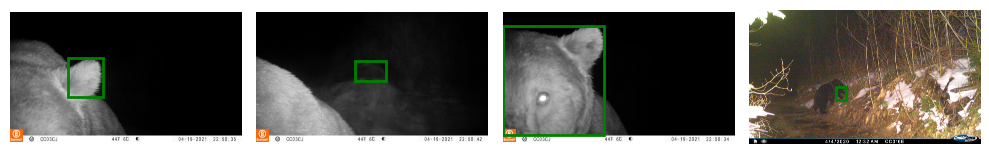

In [45]:
display_entries(df_annotated.sample(n=4), ncols=4)

### Images without bbox

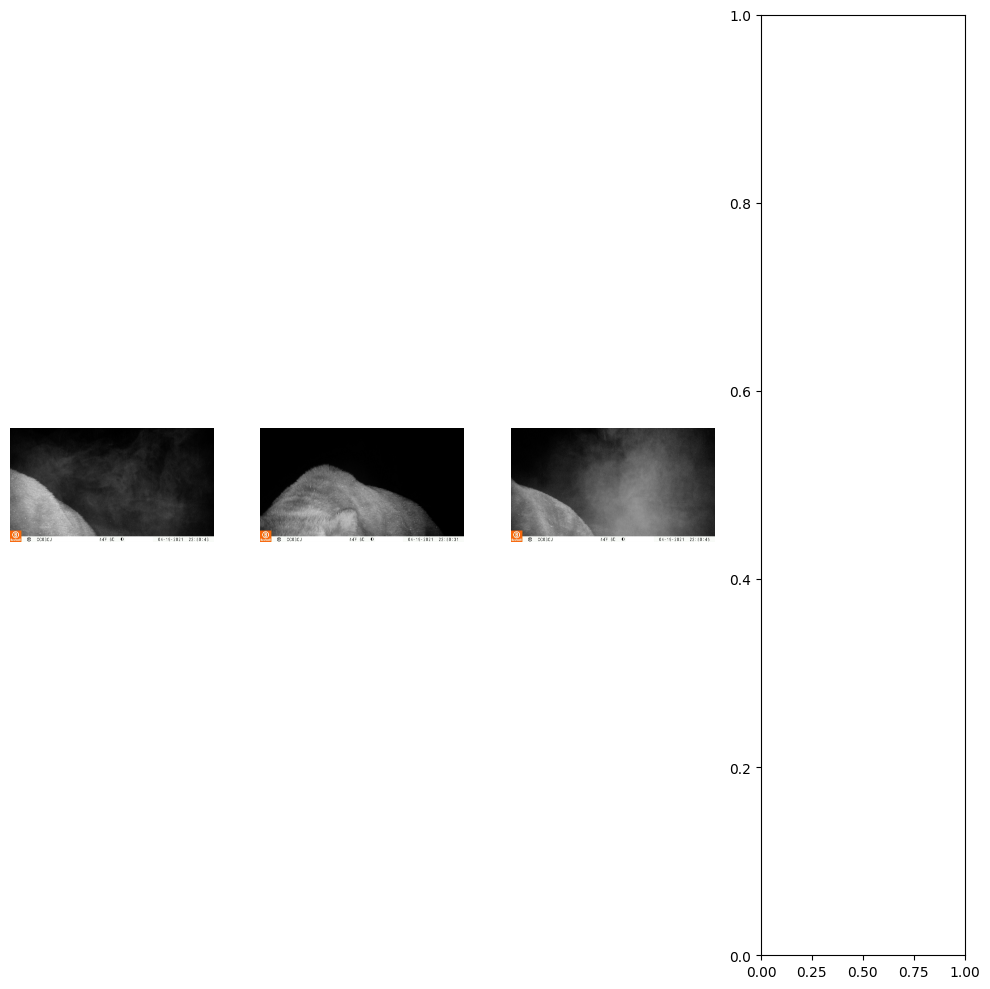

In [48]:
display_entries(df_no_annotation.sample(n=3), ncols=4)

### Truncated images

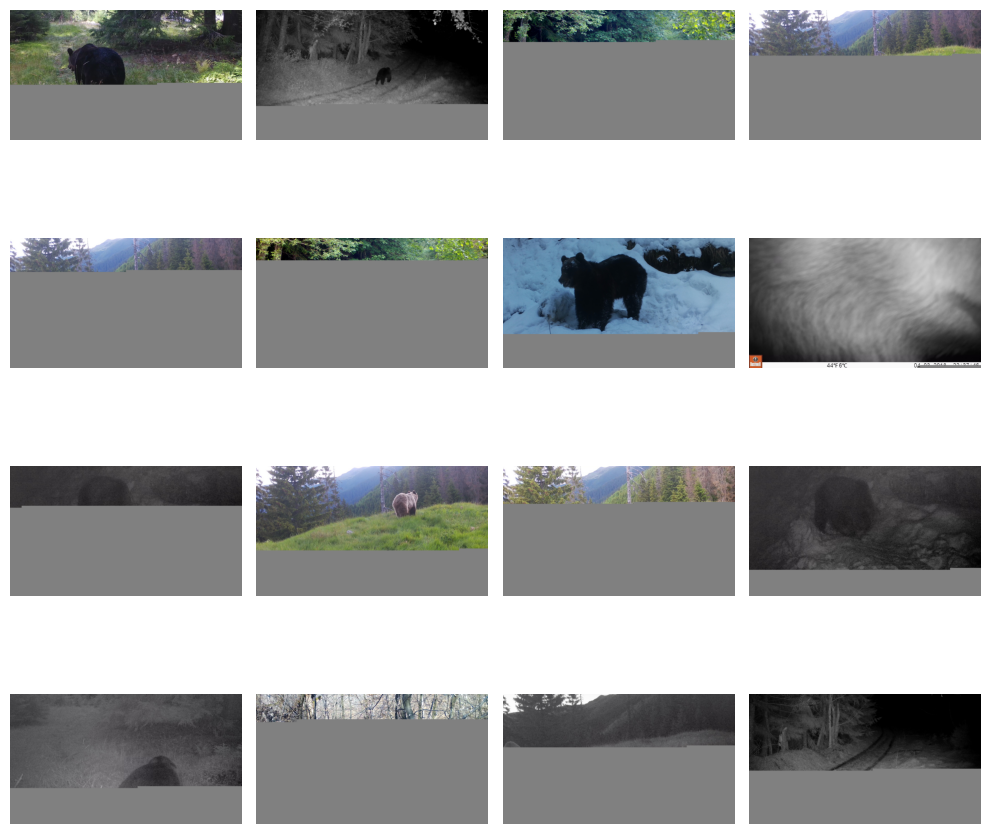

In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
display_entries(df_image_pb.sample(n=16), ncols=4)

In [29]:
imgs_without_ann_file = []
for img_path in image_paths:
    img_rel_path = relative_image_path = path.relpath(img_path, input_dir)
    ann_rel_path = path.splitext(img_rel_path)[0] + '.txt'
    ann_path = path.join(output_dir, ann_rel_path)
    other_ann_path = path.join(output_dir, 'fixed', ann_rel_path)
    Path(path.dirname(other_ann_path)).mkdir(parents=True, exist_ok=True)
    
    try:
        with open(ann_path, 'r') as f_ann:
            reader_ann = csv.reader(f_ann)
            lines = [row for row in reader_ann]
            numeric_values = [float(v) for v in lines[0][0].split(' ')] if lines else []
            with open(other_ann_path, 'w') as f_other_ann:
                writer = csv.writer(f_other_ann)
                if numeric_values:
                    writer.writerow(numeric_values)        
    except FileNotFoundError as err:
        imgs_without_ann_file.append(img_path)